# Para ejecutar en Google Colab en Drive

In [ ]:
# Montamos el Drive al Notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# Verificamos el directorio en el que nos encontramos
!pwd
!ls

In [ ]:
# Cambiamos de directorio al Drive
# TODO: change path
import os
os.chdir("drive/My Drive/PruebasCOLAB3/trajpred-bdl/tests")
!ls

# Inicio de Código

In [1]:

# Imports
import sys,os,logging, argparse
''' TF_CPP_MIN_LOG_LEVEL
0 = all messages are logged (default behavior)
1 = INFO messages are not printed
2 = INFO and WARNING messages are not printeds
3 = INFO, WARNING, and ERROR messages are not printed
'''
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.append('../bayesian-torch')
sys.path.append('../OF-PathPred')
sys.path.append('..')
import math,numpy as np
# Important imports
import matplotlib.pyplot as plt
from path_prediction.datasets_utils import setup_loo_experiment
from path_prediction.testing_utils import evaluation_minadefde,evaluation_qualitative,evaluation_attention,plot_comparisons_minadefde, get_testing_batch
from path_prediction.training_utils import Experiment_Parameters

import torch
torch.manual_seed(1)
from torchvision import transforms
import torch.optim as optim

# Local models
from models.lstm_encdec_variational import lstm_encdec_variational
from utils.datasets_utils import traj_dataset

In [2]:
logging.basicConfig(format='%(levelname)s: %(message)s',level=20)
# GPU
if torch.cuda.is_available():
    logging.info(torch.cuda.get_device_name(torch.cuda.current_device()))


INFO: NVIDIA GeForce GTX 1060


In [16]:
# Load the default parameters
experiment_parameters = Experiment_Parameters(add_kp=False,obstacles=False)

dataset_dir   = "../OF-PathPred/datasets/"
dataset_names = ['eth-hotel','eth-univ','ucy-zara01','ucy-zara02','ucy-univ']
#dataset_names = ['eth-hotel','eth-univ','ucy-zara01']
idTest        = 2
pickle        = True

In [17]:
# Load the dataset and perform the split
training_data, validation_data, test_data, test_homography = setup_loo_experiment('ETH_UCY',dataset_dir,dataset_names,idTest,experiment_parameters,pickle_dir='../pickle',use_pickled_data=pickle)

INFO: Testing/validation dataset: ['ucy-zara01']
INFO: Training datasets: ['eth-hotel', 'eth-univ', 'ucy-zara02', 'ucy-univ']
INFO: Unpickling...
INFO: Training data: 15481
INFO: Test data: 2356
INFO: Validation data: 1720


In [18]:
num_epochs     = 45
initial_lr     = 0.02
batch_size     = 128
num_mc = 1

In [19]:
# Creamos el dataset para torch
train_data = traj_dataset(training_data['obs_traj_rel'], training_data['pred_traj_rel'],training_data['obs_traj'], training_data['pred_traj'])
val_data = traj_dataset(validation_data['obs_traj_rel'], validation_data['pred_traj_rel'],validation_data['obs_traj'], validation_data['pred_traj'])
test_data = traj_dataset(test_data['obs_traj_rel'], test_data['pred_traj_rel'], test_data['obs_traj'], test_data['pred_traj'])

In [20]:
# Form batches
batched_train_data = torch.utils.data.DataLoader( train_data, batch_size = batch_size, shuffle=True)
batched_val_data =  torch.utils.data.DataLoader( val_data, batch_size = batch_size, shuffle=True)
batched_test_data =  torch.utils.data.DataLoader( test_data, batch_size = batch_size, shuffle=True)

In [21]:
prior_mu = 0.0
prior_sigma = 1.0
posterior_mu_init = 0.0
posterior_rho_init = -3.0 # 0.006715348489117967 # 0.01814992791780978 # 0.04858735157374196

In [22]:
# Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = lstm_encdec_variational(2,128,256,2,prior_mu,prior_sigma,posterior_mu_init,posterior_rho_init)
model.to(device)

lstm_encdec_variational(
  (embedding): LinearReparameterization()
  (lstm1): LSTMReparameterization(
    (ih): LinearReparameterization()
    (hh): LinearReparameterization()
  )
  (lstm2): LSTMReparameterization(
    (ih): LinearReparameterization()
    (hh): LinearReparameterization()
  )
  (decoder): LinearReparameterization()
  (loss_fun): MSELoss()
)

In [23]:
import torch.optim as optim

# Training the Model
optimizer = optim.SGD(model.parameters(), lr=initial_lr)

#optimizer = optim.SGD(model.parameters(), lr=0.015)
#optimizer = optim.SGD(model.parameters(), lr=0.03)
#optimizer = optim.SGD(model.parameters(), lr=0.05)
#optimizer = optim.SGD(model.parameters(), lr=0.08) #nan
#optimizer = optim.SGD(model.parameters(), lr=0.07) #nan 
#optimizer = optim.SGD(model.parameters(), lr=0.06) #nan 

num_mc = 10

nl_loss_ = []
kl_loss_ = []
for epoch in range(num_epochs):
    # Training
    print("----- ")
    print("epoch: ", epoch)
    error = 0
    total = 0
    M     = len(batched_train_data)
    for batch_idx, (data, target, _a , _b) in enumerate(batched_train_data):
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        if torch.cuda.is_available():
            data  = data.to(device)
            target=target.to(device)

        # Step 2. Run our forward pass and compute the losses
        pred, nl_loss, kl_loss = model(data, target, training=True, num_mc=num_mc)
        
        nl_loss_.append(nl_loss.detach().item())
        kl_loss_.append(kl_loss.detach().item())
        
        # TODO: Divide by the batch size
        #pi     = (2.0**(M-batch_idx))/(2.0**M-1) #  Blundell?
        loss   = nl_loss+ kl_loss/M
        error += loss.detach().item()
        total += len(target)

        # Step 3. Compute the gradients, and update the parameters by
        loss.backward()
        optimizer.step()
    print("Average training loss: {:.3e}".format(error/total))

    # Validation
    error = 0
    total = 0
    M     = len(batched_val_data)
    for batch_idx, (data_val, target_val, _ , _) in enumerate(batched_val_data):
        if torch.cuda.is_available():
            data_val  = data_val.to(device)
            target_val=target_val.to(device)
        pred_val, nl_loss, kl_loss = model(data_val, target_val)
        pi     = (2.0**(M-batch_idx))/(2.0**M-1) # From Blundell
        loss   = nl_loss+ pi*kl_loss
        error += loss.detach().item()
        total += len(target_val)

    print("Average validation loss: {:.3e}".format(error/total))


----- 
epoch:  0
Average training loss: 1.187e+00
Average validation loss: 3.850e-01
----- 
epoch:  1
Average training loss: 1.149e+00
Average validation loss: 3.707e-01
----- 
epoch:  2
Average training loss: 1.131e+00
Average validation loss: 3.596e-01
----- 
epoch:  3
Average training loss: 1.113e+00
Average validation loss: 3.687e-01
----- 
epoch:  4
Average training loss: 1.096e+00
Average validation loss: 3.593e-01
----- 
epoch:  5
Average training loss: 1.078e+00
Average validation loss: 3.425e-01
----- 
epoch:  6
Average training loss: 1.061e+00
Average validation loss: 3.386e-01
----- 
epoch:  7
Average training loss: 1.045e+00
Average validation loss: 3.298e-01
----- 
epoch:  8
Average training loss: 1.028e+00
Average validation loss: 3.611e-01
----- 
epoch:  9
Average training loss: 1.012e+00
Average validation loss: 3.241e-01
----- 
epoch:  10
Average training loss: 9.969e-01
Average validation loss: 3.202e-01
----- 
epoch:  11
Average training loss: 9.820e-01
Average valid

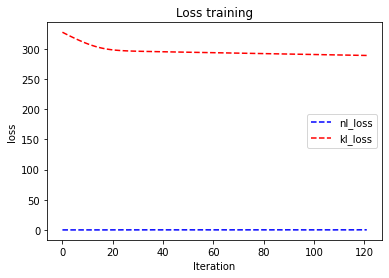

In [16]:
plt.plot(nl_loss_,"--b", label="nl_loss")
plt.plot(kl_loss_,"--r", label="kl_loss")
plt.title("Loss training")
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

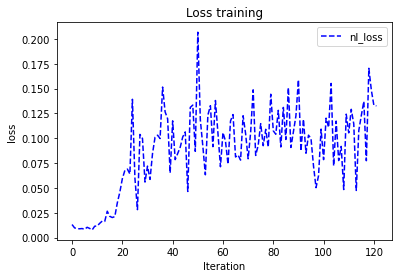

In [17]:
plt.plot(nl_loss_,"--b", label="nl_loss")
plt.title("Loss training")
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

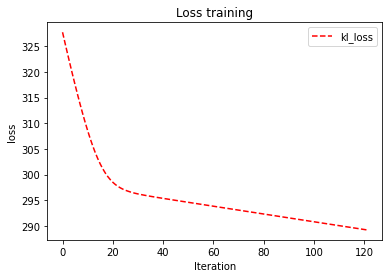

In [18]:
plt.plot(kl_loss_,"--r", label="kl_loss")
plt.title("Loss training")
plt.xlabel("Iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

In [19]:
# Guardamos el Modelo
torch.save(model.state_dict(), "../training_checkpoints/model_variational.pth")

-----
0


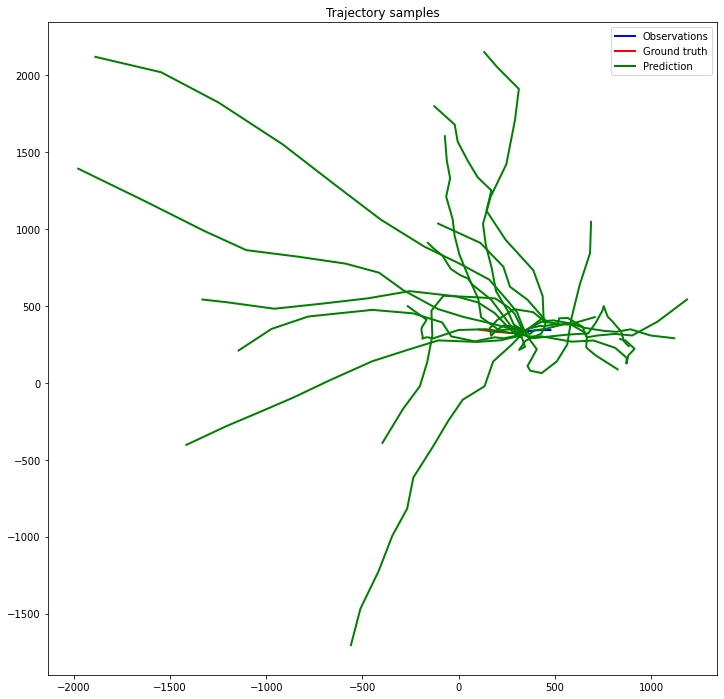

-----
1


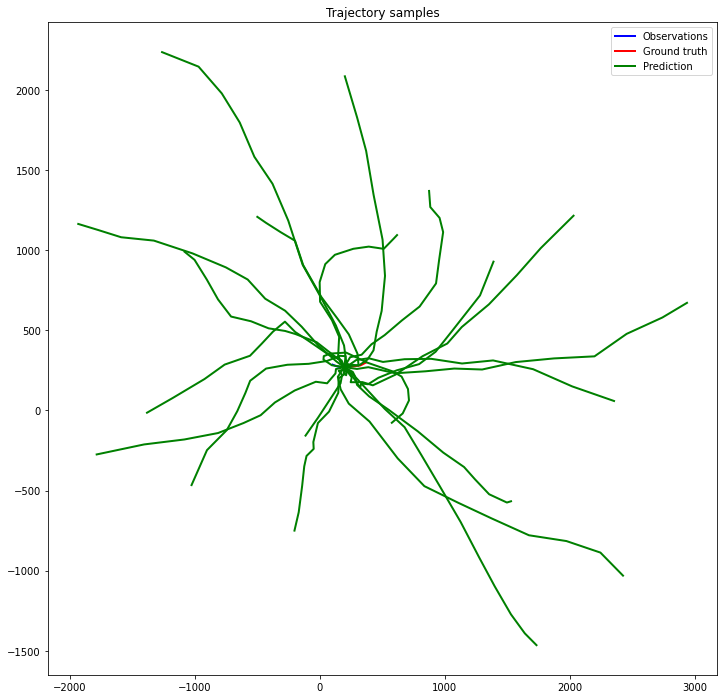

-----
2


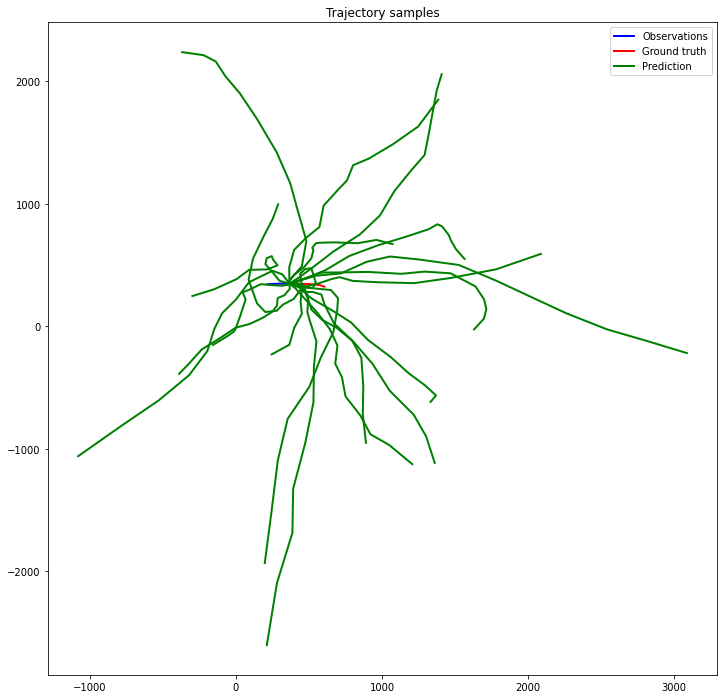

-----
3


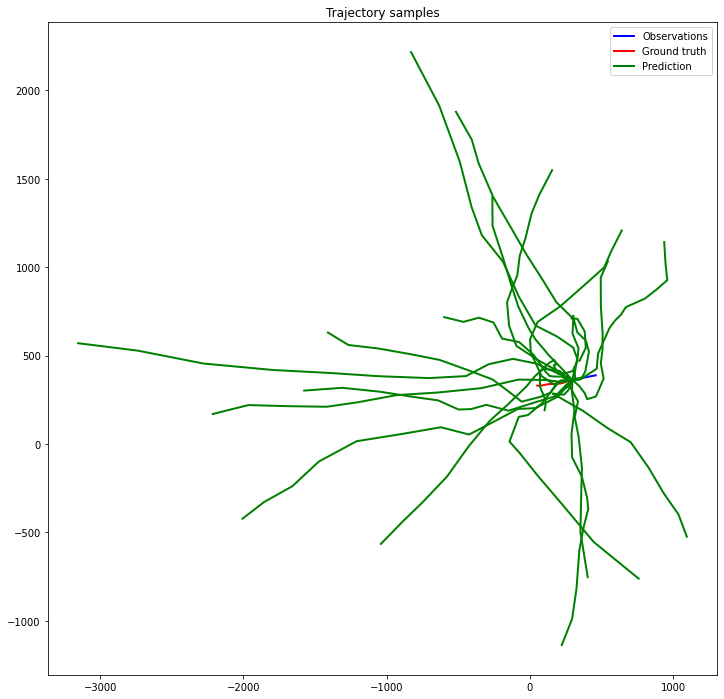

-----
4


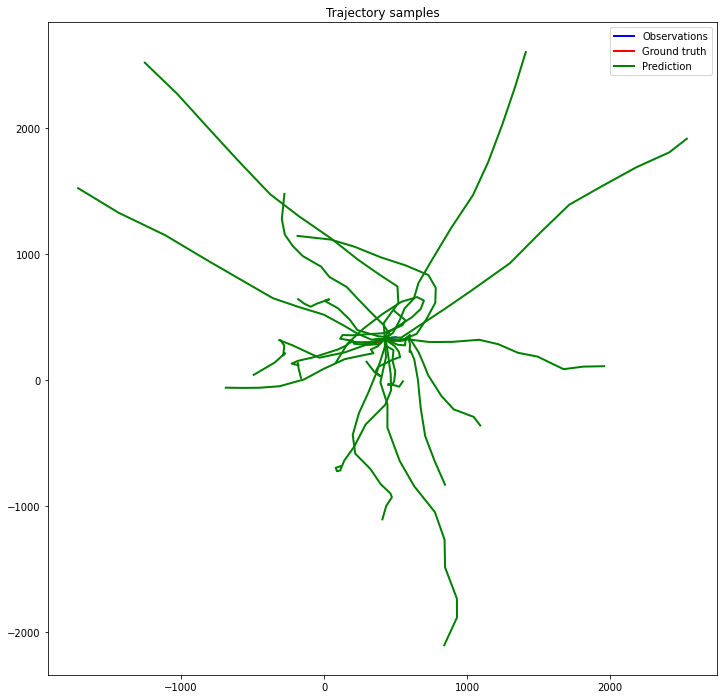

-----
5


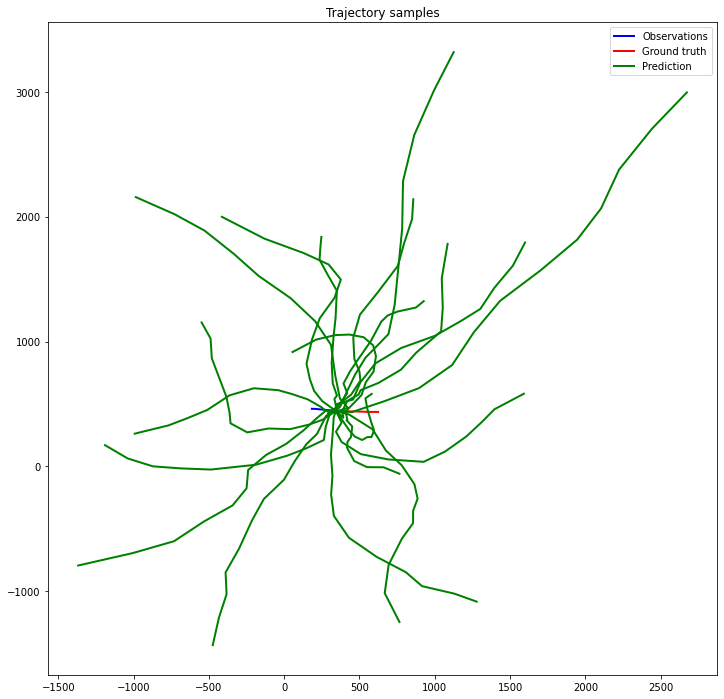

-----
6


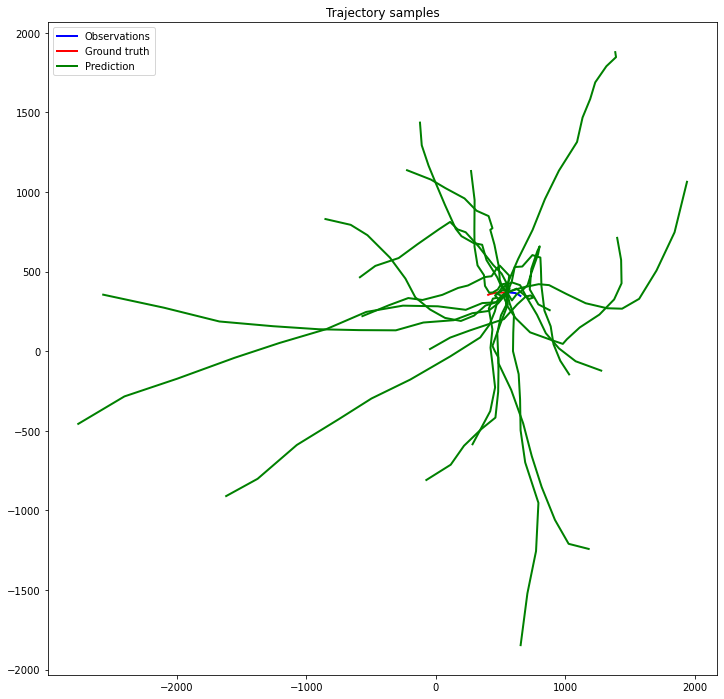

-----
7


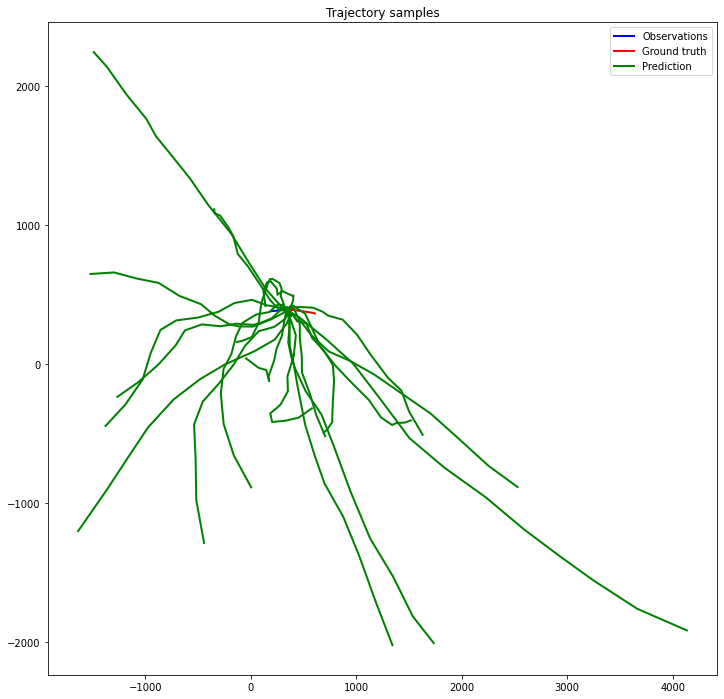

-----
8


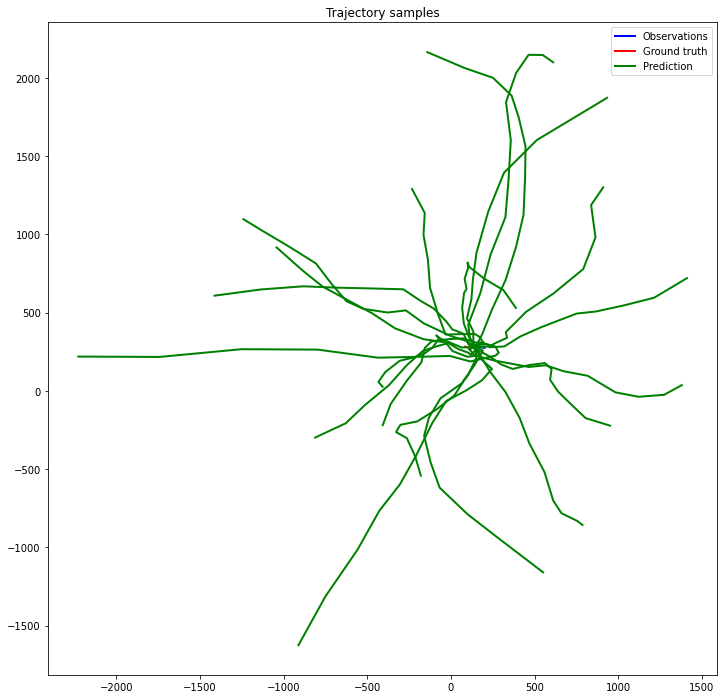

-----
9


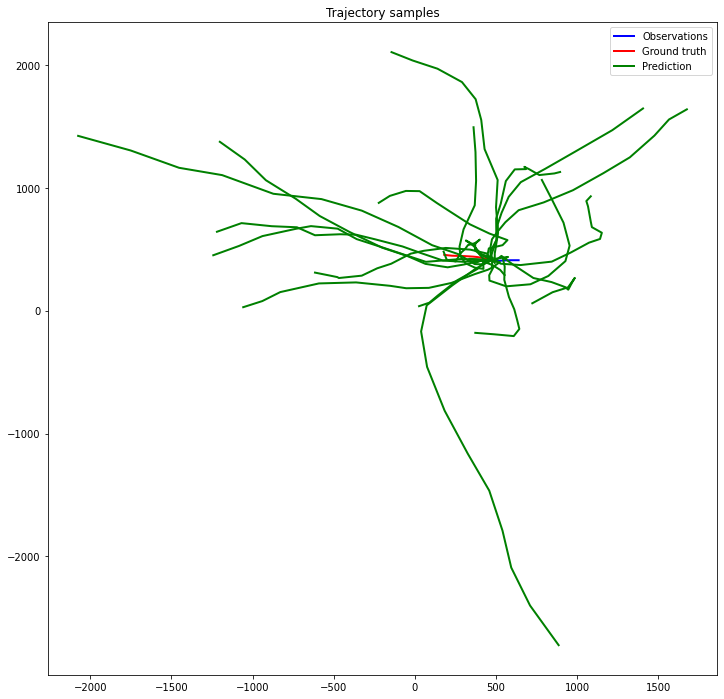

In [23]:
from path_prediction.obstacles import image_to_world_xy

num_samples = 3
num_monte_carlo = 20
i = 1 # sample of batch
draw_ellipse = True

bck = plt.imread(os.path.join(dataset_dir,dataset_names[idTest],'reference.png'))

# Testing
cont = 0
for batch_idx, (datarel_test, targetrel_test, data_test, target_test) in enumerate(batched_test_data):
    print("-----")
    print(cont)
    if torch.cuda.is_available():
        datarel_test  = datarel_test.to(device)
        targetrel_test= targetrel_test.to(device)
        data_test     = data_test.to(device)
        target_test   = target_test.to(device)
    homography = np.linalg.inv(test_homography)

    obs_traj_gt  = data_test[i,:,:]
    pred_traj_gt = target_test[i,:,:]
    obs   = image_to_world_xy(obs_traj_gt.cpu(), homography, flip=False)
    gt    = image_to_world_xy(pred_traj_gt.cpu(), homography, flip=False)
    gt = np.concatenate([obs[-1,:].reshape((1,2)), gt], axis=0)

    fig, ax1 = plt.subplots(figsize=(12,12))
    ax1.imshow(bck)
    ax1.plot(obs[:,0],obs[:,1],"-b", linewidth=2, label="Observations")
    ax1.plot(gt[:,0], gt[:,1],"-r", linewidth=2, label="Ground truth")

    x = []
    y = []
    # prediction
    for mc_run in range(num_monte_carlo):
        pred, kl  = model.predict(datarel_test, dim_pred=12)
        pred_traj = pred[i,:,:]
        # Convert it to absolute (starting from the last observed position)
        displacement      = np.cumsum(pred_traj, axis=0)
        this_pred_out_abs = displacement + np.array([obs_traj_gt[-1].cpu().numpy()])

        tpred = image_to_world_xy(this_pred_out_abs, homography, flip=False)
        x.append(tpred[:,0])
        y.append(tpred[:,1])
        
        tpred = np.concatenate([obs[-1,:].reshape((1,2)), tpred], axis=0)

        if mc_run == 0:
            ax1.plot(tpred[:,0],tpred[:,1],"-g", linewidth=2, label="Prediction")
        else:
            ax1.plot(tpred[:,0],tpred[:,1],"-g", linewidth=2)
        
    if draw_ellipse:
        # draw ellipse
        x = np.array(x)
        y = np.array(y)
        draw_ellipse_covariance(x,y,ax1,alpha=0.3)
    
    ax1.legend()
    plt.title('Trajectory samples')
    plt.savefig("traj_variational_1_4"+str(cont)+".pdf")
    plt.show()

    if draw_ellipse:
        fig, ax2 = plt.subplots()
        draw_ellipse_covariance(x,-y,ax2,alpha=0.2)
        plt.title('Ellipse covariance')
        plt.savefig("traj_variational_ellipsesCovariance_1_4"+str(cont)+".pdf")
        plt.show()

    cont += 1

    if cont == num_samples:
        break